# TD 1 - Révolutions : Explorations du terme à partir de Wikipedia

## 1. Extraire le corpus

Importons tout d'abord les bibliothèques nécessaires à l'extraction des données sur Wikipedia.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import requests

Ensuite, connectons-nous sur la page "Révolution (homonymie)" pour tenter de récupérer une liste des diverses expressions différentes du terme "révolution" dans l'encyclopédie.

In [2]:
url = "https://fr.wikipedia.org/wiki/R%C3%A9volution_(homonymie)"
base_url = "https://fr.wikipedia.org"
r = requests.get(url)
soup = BeautifulSoup(r.text, "html5lib")
# Let's get the body of the article
body = soup.find("div", attrs={"class", "mw-parser-output"})
# Get the list of h2
h3 = body.find_all("h3")

Construisons maintenant le modèle de notre futur tableau de données.

In [3]:
links = {"liens": [],
        "nom_page": []}

A présent, passons à la récupération des données filtrées. On ne récupère que le titre et le lien vers chacun des pages rencontrées dans la page Wikipedia. Nous ferons un peu de nettoyage plus tard.

In [4]:
hrefs = body.find_all("a")
regex = re.compile("[Rr][ée]volution[s]?")

for l in hrefs:
    try:
        if re.match(regex, l["title"]):
            links["liens"].append(base_url + l["href"])
            links["nom_page"].append(l["title"])
    except:
        pass

A partir des données récupérées, on peut créer un tableau qui contiendra le nom des pages et les liens. Grâce à cela, on pourra récupérer le text intégral des pages Wikipedia qui nous intéressent.

In [5]:
df = pd.DataFrame(links)

Ajoutons maintenant le texte intégral des pages web qui nous intéressent dans notre tableau.

In [6]:
full_text = []

In [7]:
for link in tqdm(df.iterrows()):
    r = requests.get(link[1]["liens"])
    soup = BeautifulSoup(r.text, "html5lib")
    try:
        body = soup.find("div", attrs={"class", "mw-content-container"})
        full_text.append(body.get_text())
    except AttributeError:
        full_text.append(soup.get_text())

76it [00:35,  2.17it/s]


In [8]:
df["full_text"] = full_text

Nous pouvons maintenir exporter le résultat dans un tableau CSV.

In [9]:
df.to_csv("revolution.csv", sep=";", encoding="utf-8")

Nous pouvons créer une fonction pour nettoyer les corpus.

In [10]:
df.head()

,liens,nom_page,full_text
0,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution industrielle,\n\n\n\t\n\t\n\t\n\t\n\tRévolution industriell...
1,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution (politique et sociale),\n\n\n\t\n\t\n\t\n\t\n\tRévolution\n\t\n\t\tUn...
2,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution sociale,\n\n\n\t\n\t\n\t\n\t\n\tRévolution sociale\n\t...
3,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution néolithique,\n\n\n\t\n\t\n\t\n\t\n\tRévolution néolithique...
4,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution agricole,\n\n\n\t\n\t\n\t\n\t\n\tRévolution agricole\n\...


## 2. Nettoyage du corpus

Nous récupérons un corpus de texte brut qu'il nous faut nettoyer avant de l'utiliser.

Premièrement, retirons tous les "grands" caractères d'espacement (`\n`, `\t`).

In [18]:
def remove_widespaces(text):
    regex = re.compile(r"\n|\t")
    text = re.sub(regex, " ", text)
    return text

Ensuite, retirons les espaces non sécables.

In [19]:
def remove_nonbreaking_spaces(text):
    regex = re.compile(r"\xa0")
    text = re.sub(regex, " ", text)
    return text

Retirons maintenant les notes inscrites entre crochets.

In [20]:
def remove_notes(text):
    regex = re.compile(r"\[*?\]")
    text = re.sub(regex, " ", text)
    return text

Ensuite, retirons des éléments de formatage de Wikipedia.

In [21]:
def remove_wikicode(text):
    regex = re.compile(r"\[modifier | modifier le code")
    text = re.sub(regex, " ", text)
    return text

Enfin, retirons les notes numérotées mal formatées.

In [22]:
def remove_num_notes(text):
    regex = re.compile(r"\[\d+")
    text = re.sub(regex, " ", text)
    return text

Retirons également les barres obliques.

In [23]:
def remove_vertical(text):
    regex = re.compile(r"\|")
    text = re.sub(regex, " ", text)
    return text

Enfin, retirons les flèches verticales utilisées dans les notes de bas de page.

In [24]:
def remove_arrow(text):
    regex = re.compile(r"↑")
    text = re.sub(regex, " ", text)
    return text

Appliquons toutes les fonctions de nettoyage sur le corpus.

In [27]:
for index, row in df.iterrows():
    new_row = remove_arrow(remove_vertical(remove_num_notes(remove_wikicode(remove_notes(remove_nonbreaking_spaces(remove_widespaces(row["full_text"])))))))
    row["full_text"] = new_row

Exportons à présent le corpus nettoyé.

In [78]:
df.to_csv("revolution_clean.csv", sep=";", encoding="utf-8")

Certains des éléments retenus dans le tableau pointent en réalité vers des pages Wikipedia en cours de création qui ne contiennent pas actuellement de contenu. Nous allons donc les retirer du corpus.

In [79]:
df = pd.read_csv("revolution_clean.csv", sep=";", encoding="utf8")
df.drop(columns=["Unnamed: 0"], inplace=True)

,liens,nom_page,full_text
26,https://fr.wikipedia.org/wiki/R%C3%A9volution_!,Révolution !,Révolution ! Un article de Wik...
37,https://fr.wikipedia.org/wiki/R%C3%A9volutions...,Révolutions (album),Révolutions (album) Un article...
36,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution (Ève Angeli),Révolution (album d'Ève Angeli) ...
2,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution sociale,Révolution sociale Un article ...
16,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution des Œillets,Révolution des Œillets Un arti...
39,https://fr.wikipedia.org/wiki/Revolution_909,Revolution 909,Revolution 909 Un article de W...
14,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution française de 1848,Révolution française de 1848 U...
23,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution kirghize de 2010,Révolution kirghize de 2010 Un...
20,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution des Roses,Révolution des Roses Un articl...
34,https://fr.wikipedia.org/wiki/Revolution_X,Revolution X,Revolution X Un article de Wik...


In [76]:
for index, row in df.iterrows():
    if "page inexistante" in row["nom_page"]:
        df.drop([index], inplace=True)
df

,liens,nom_page,full_text
0,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution industrielle,Révolution industrielle Un art...
1,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution (politique et sociale),Révolution Un article de Wikip...
2,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution sociale,Révolution sociale Un article ...
3,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution néolithique,Révolution néolithique Un arti...
4,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution agricole,Révolution agricole Un article...
5,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution verte,Révolution verte Un article de...
6,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution scientifique,Révolution scientifique Un art...
7,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution copernicienne,Révolution copernicienne Un ar...
8,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution industrielle,Révolution industrielle Un art...
9,https://fr.wikipedia.org/wiki/R%C3%A9volution_...,Révolution sexuelle,Révolution sexuelle Un article...


In [81]:
df.to_csv("revolution_clean.csv", sep=";", encoding="utf-8")

## 3. Préparation du corpus pour Iramuteq

In [1]:
import pandas as pd

Importons le tableau contenant toutes les données et les corpus pour ne pas avoir à reproduire toute la procédure à chaque fois que l'on veut faire un nouvel export texte du corpus Wikipedia.

In [2]:
df_clean = pd.read_csv("revolution_clean.csv", sep=";", encoding="utf-8")

Ajoutons ici les variables en en-tête de chaque texte du corpus et préparons-le pour l'export en .txt pour l'analyse Iramuteq.

In [3]:
title = []
full_text = []

for index, row in df_clean.iterrows():
    title_nospace = row["nom_page"].replace(" ", "-").replace("é", "e")
    title.append(title_nospace)
    full_text.append(row["full_text"])


with open("corpus/corpus_revolution_iramuteq.txt", "w", encoding="utf-8") as file:
    for t, f in zip(title, full_text):
        
        file.write(f"**** *titre_{t} \n\n {f} \n\n")

## 4. Analyse exploratoire

Pour tenir compte de la spécificité de chaque texte, explorons quelques éléments statistiques sur ce corpus.

In [6]:
len_article = []
nom_page = []

for i in range(0, len(df_clean)):
    len_article.append(len(df_clean.at[i, "full_text"]))
    nom_page.append(df_clean.at[i, "nom_page"])

Voyons tout d'abord quel est l'article le plus long.

In [7]:
print(np.array(len_article).max())
print(nom_page[13])

181437
Révolution française


Sans trop de surprise, il s'agit de l'article traitant de la Révolution française qui est le plus long.

Ajoutons la longueur de chaque texte à notre tableau de données.

In [8]:
df_clean["len_article"] = len_article

A présent, on peut trier notre tableau de données en fonction de la taille de chaque texte.

In [9]:
df_len = df_clean.sort_values("len_article", ascending=False)

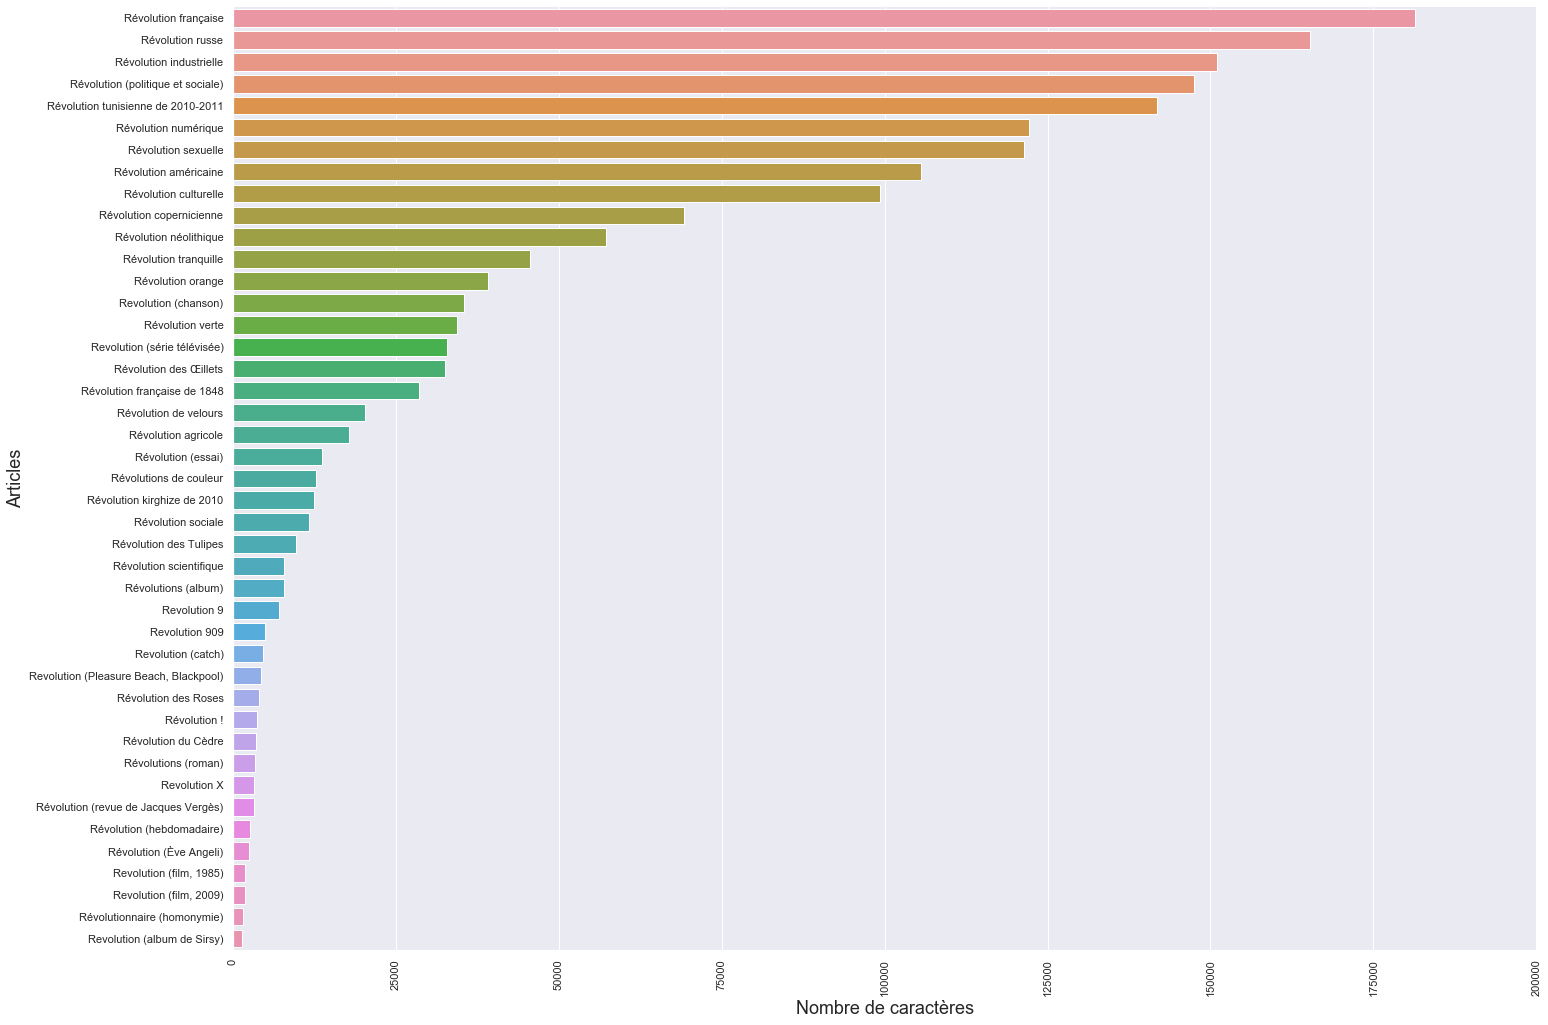

In [10]:
sns.set_theme(context="notebook", style="darkgrid")
plot = sns.catplot(data=df_len, y=df_len["nom_page"], x=df_len["len_article"], kind="bar")
plot.fig.set_figwidth(50)
plot.fig.set_figheight(15)
plot.set_xlabels("Nombre de caractères", size=18)
plot.set_ylabels("Articles", size=18)
plot.set_xticklabels(rotation=90)
plot.savefig("len_article.png")